In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import itertools
from nltk.tokenize import WordPunctTokenizer
import nltk
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import re
import langid
from nltk.corpus import stopwords


Helper Functions

In [23]:
def preprocess_lyrics(lyrics, song_name):  

    language, _ = langid.classify(lyrics)
    if language != 'en':
        lyrics = song_name
    try:
        lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    except Exception as e:
        print("error:", lyrics)
        return "" 
    if len(lyrics) > 5000:
        lyrics = song_name
    # Convert to lowercase
    lyrics = lyrics.lower()

    return lyrics

class POSTogging:
    def __init__(self):
        self.wpt = WordPunctTokenizer()
    def __call__(self, doc):
        text = self.wpt.tokenize(doc)
        return [word + '/' + tag for word, tag in nltk.pos_tag(text)]

Data Loading and preprocessing

In [24]:
df = pd.read_csv('shuffled_900.csv')
df.head()

,Unnamed: 0,name,album,artist,id,release_date,popularity,length,danceability,acousticness,...,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood,lyrics
0,70,Wish You Were Sober,Kid Krow,Conan Gray,0kn2gu8Pd03DiYHzRvX2Xk,2020-03-20,77,168880,0.701,0.0178,...,0.00000,0.170,0.6960,-5.226,0.0468,91.071,2,4,Energetic,74 ContributorsTranslationsPortuguêsTürkçeEspa...
1,827,Unfaithful,A Girl Like Me,Rihanna,13xxBnXOuiBxVxJI458B0i,2006-04-10,73,226973,0.588,0.8390,...,0.00000,0.227,0.3490,-8.607,0.0334,144.069,0,4,Calm,49 ContributorsUnfaithful Lyrics\nStory of my ...
2,231,Orbits,Orbits,Halfway Escape,6jFX2sHOzh7tpIIOomlrqJ,2020-07-07,33,204827,0.438,0.8550,...,0.88100,0.110,0.4000,-13.924,0.0390,116.142,6,4,Calm,3 ContributorsThe Age of Lead LyricsThe man ha...
3,588,Water Colors,Water Colors,Star Slide,7rpGOF9MwCP2Oaz9yDO452,2019-09-18,50,182079,0.465,0.6330,...,0.93700,0.085,0.0659,-19.328,0.0386,72.021,7,4,Calm,1 ContributorRed Cartel Lyrics\nUsed to pour a...
4,39,Sweet Nothing,Midnights (The Til Dawn Edition),Taylor Swift,2L09RYwH5Pjzca6PmbUAw3,2023-05-26,67,188496,0.335,0.9670,...,0.00012,0.115,0.3910,-14.958,0.0480,175.917,0,4,Calm,NaN


In [25]:
df = df.fillna('')
df['lyrics'] = df.apply(lambda row: row['name'] if pd.isnull(row['lyrics']) else row['lyrics'], axis=1)
lyrics_list = df['lyrics'].to_list()
lyrics_name = df['name'].to_list()
df['filtered_lyrics'] = [preprocess_lyrics(lyrics, song_name) for lyrics, song_name in zip(lyrics_list, lyrics_name)]

df = df.dropna(subset=['filtered_lyrics']).reset_index(drop=True)
preprocessed_lyrics_list = df['filtered_lyrics'].to_list()

In [27]:
col_features = df.columns[6:-3]
print(col_features)
X = MinMaxScaler().fit_transform(df[col_features])
Y = df['mood']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

Index(['popularity', 'length', 'danceability', 'acousticness', 'energy',
       'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
       'tempo', 'key', 'time_signature'],
      dtype='object')


### XGBoost model

In [28]:
min_df_list = [3]
max_features_list = [250]

models_pipeline = dict()
models_pipeline['Xgboost'] = xgb.XGBClassifier(n_estimators=60, random_state=42)


In [29]:
text_file = open("model_results.txt","w+")

for models_name in models_pipeline.keys():
    for min_df_item in min_df_list:
        for max_features_item in max_features_list:
            tf_idf_vectorizer = TfidfVectorizer(min_df=min_df_item, max_features=max_features_item, strip_accents='unicode', 
                                  lowercase=True, analyzer='word', token_pattern=r'\w{3,}', 
                                  ngram_range=(1, 1), use_idf=True, smooth_idf=True, 
                                  sublinear_tf=True, stop_words="english")
            tf_idf_vectorizer_pos = TfidfVectorizer(min_df=min_df_item, max_features=max_features_item, strip_accents='unicode', 
                                  lowercase=True, analyzer='word', token_pattern=r'\w{3,}', 
                                  ngram_range=(1, 1), use_idf=True, smooth_idf=True, 
                                  sublinear_tf=True, stop_words="english", tokenizer=POSTogging())
            model = models_pipeline[models_name]
            lyrics_tfidf_features = tf_idf_vectorizer.fit_transform(preprocessed_lyrics_list).toarray()
            X_combined = np.concatenate((X, lyrics_tfidf_features), axis=1)
            X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.25, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            train_accuracy = accuracy_score(model.predict(X_train), y_train)
            test_accuracy = accuracy_score(y_pred, y_test)

            stream = str(models_name) + " :  TF IDF (" + str(min_df_item) + ", " + str(max_features_item) + ") : " + str(train_accuracy) + " :" + str(test_accuracy)
            print(stream)
            text_file.write(stream + "\n")
text_file.close()

Xgboost :  TF IDF (3, 250) : 1.0 :0.8222222222222222


### Logistic Regression

In [30]:
y_train_encoded = y_train
y_test_encoded = y_test
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train_encoded)
y_pred = model.predict(X_test)

train_accuracy = accuracy_score(model.predict(X_train), y_train_encoded)
test_accuracy = accuracy_score(y_pred, y_test_encoded)

print("train accuracy:", train_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 0.8681481481481481
test accuracy: 0.7555555555555555


In [31]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Ref: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(pad=5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

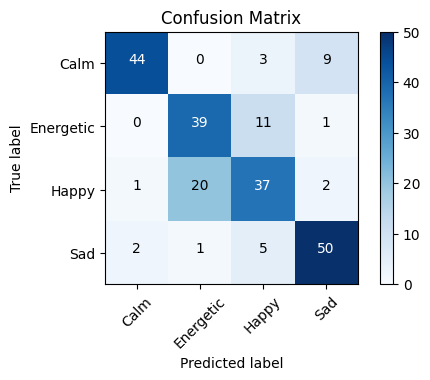

In [32]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

y_test = label_encoder.inverse_transform(y_test_encoded)
cnf_matrix = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()

263


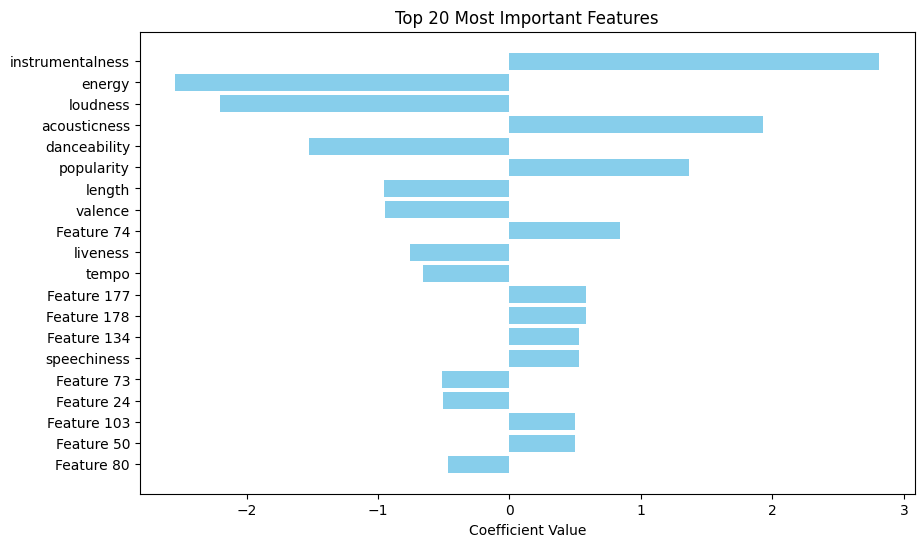

In [33]:
#plotting the top20 coefficients
coefficients = model.coef_[0]
feature_names = [f'Feature {i}' for i in range(len(coefficients))]

abs_coefficients = np.abs(coefficients)


sorted_indices = np.argsort(abs_coefficients)[::-1]  
print(len(sorted_indices))
top_n = 20 
for i in range(len(col_features)):
    feature_names[i] = col_features[i]

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_indices[:top_n]], coefficients[sorted_indices[:top_n]], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()
plt.show()

### CatBoost model

Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86        56
           1       0.70      0.86      0.77        51
           2       0.78      0.65      0.71        60
           3       0.75      0.88      0.81        58

    accuracy                           0.79       225
   macro avg       0.80      0.79      0.79       225
weighted avg       0.80      0.79      0.79       225



/home/sathu/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


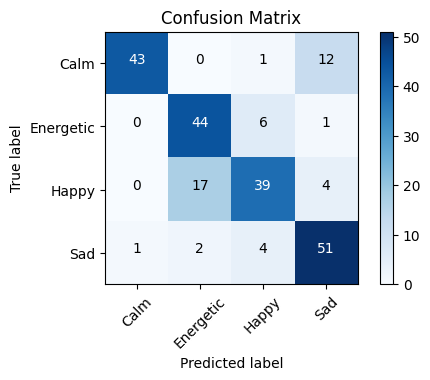

In [34]:
import catboost as cb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

catboost_classifier = cb.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.05, loss_function='MultiClass')
catboost_classifier.fit(X_train, y_train_encoded, eval_set=(X_test, y_test_encoded), verbose=False)

predictions = catboost_classifier.predict(X_test)
accuracy = accuracy_score(y_test_encoded, predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, predictions))

y_pred_decoded = label_encoder.inverse_transform(predictions)
y_test = label_encoder.inverse_transform(y_test_encoded)

cnf_matrix_catboost = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_catboost, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()


### XGBoost model

XGBoost Train Accuracy: 1.00
XGBoost Test Accuracy: 0.82


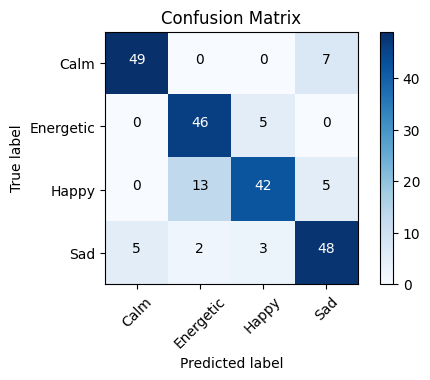

In [35]:

xgb_classifier = xgb.XGBClassifier(n_estimators=60, random_state=42)
xgb_classifier.fit(X_train, y_train_encoded)

xgb_train_preds = xgb_classifier.predict(X_train)
xgb_predictions = xgb_classifier.predict(X_test)
accuracy_xgb_train = accuracy_score(y_train_encoded, xgb_train_preds)
accuracy_xgb = accuracy_score(y_test_encoded, xgb_predictions)
print(f"XGBoost Train Accuracy: {accuracy_xgb_train:.2f}")
print(f"XGBoost Test Accuracy: {accuracy_xgb:.2f}")

y_pred_decoded = label_encoder.inverse_transform(xgb_predictions)
y_test = label_encoder.inverse_transform(y_test_encoded)

cnf_matrix_xgb = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_xgb, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()


### Neural Networks
#### 2 linear layers

Epoch [1/50] Loss: 0.285794198513031
Epoch [2/50] Loss: 0.14872299134731293
Epoch [3/50] Loss: 0.49235799908638
Epoch [4/50] Loss: 0.0652693584561348
Epoch [5/50] Loss: 0.03343668952584267
Epoch [6/50] Loss: 0.22672224044799805
Epoch [7/50] Loss: 0.04445534944534302
Epoch [8/50] Loss: 0.12855158746242523
Epoch [9/50] Loss: 0.05668136477470398
Epoch [10/50] Loss: 0.09348255395889282
Epoch [11/50] Loss: 0.0003679718356579542
Epoch [12/50] Loss: 0.011079584248363972
Epoch [13/50] Loss: 0.061164647340774536
Epoch [14/50] Loss: 0.004318702965974808
Epoch [15/50] Loss: 0.03073415905237198
Epoch [16/50] Loss: 0.0018879497656598687
Epoch [17/50] Loss: 0.0001800946774892509
Epoch [18/50] Loss: 0.001668443321250379
Epoch [19/50] Loss: 0.022457808256149292
Epoch [20/50] Loss: 0.06833411753177643
Epoch [21/50] Loss: 0.5059714913368225
Epoch [22/50] Loss: 0.05664673447608948
Epoch [23/50] Loss: 0.005889730527997017
Epoch [24/50] Loss: 0.00018212241411674768
Epoch [25/50] Loss: 0.0023492348846048117

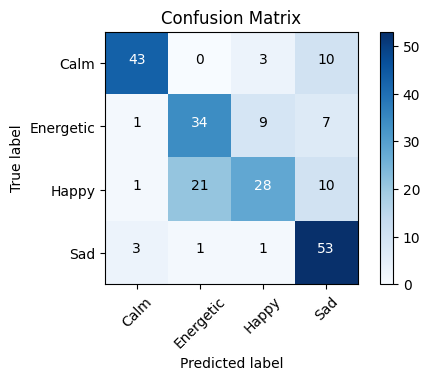

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X_combined.shape[1]
hidden_size = 300
num_classes = 4  
model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
y_preds = []
y_true = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_preds.extend(predicted.tolist())
        y_true.extend(targets.tolist())


accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2f}")


y_pred_decoded = label_encoder.inverse_transform(y_preds)
y_test = label_encoder.inverse_transform(y_true)

cnf_matrix_nn2 = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_nn2, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()

### Convolutional Neural Network

(900, 263) (675, 263)
Epoch [1/80] Loss: 0.9216254353523254
Epoch [2/80] Loss: 1.4863954782485962
Epoch [3/80] Loss: 0.38739630579948425
Epoch [4/80] Loss: 0.22613359987735748
Epoch [5/80] Loss: 0.6599363684654236
Epoch [6/80] Loss: 0.6469395160675049
Epoch [7/80] Loss: 0.06763454526662827
Epoch [8/80] Loss: 0.10333504527807236
Epoch [9/80] Loss: 0.27884945273399353
Epoch [10/80] Loss: 0.00775673845782876
Epoch [11/80] Loss: 0.3928401470184326
Epoch [12/80] Loss: 1.4007467031478882
Epoch [13/80] Loss: 0.12102780491113663
Epoch [14/80] Loss: 0.6253753304481506
Epoch [15/80] Loss: 0.1356147825717926
Epoch [16/80] Loss: 0.02642340399324894
Epoch [17/80] Loss: 0.018239425495266914
Epoch [18/80] Loss: 0.004721537698060274
Epoch [19/80] Loss: 0.13986292481422424
Epoch [20/80] Loss: 0.022839590907096863
Epoch [21/80] Loss: 0.16556981205940247
Epoch [22/80] Loss: 0.0211963951587677
Epoch [23/80] Loss: 0.009084685705602169
Epoch [24/80] Loss: 0.0007311553345061839
Epoch [25/80] Loss: 0.00039766

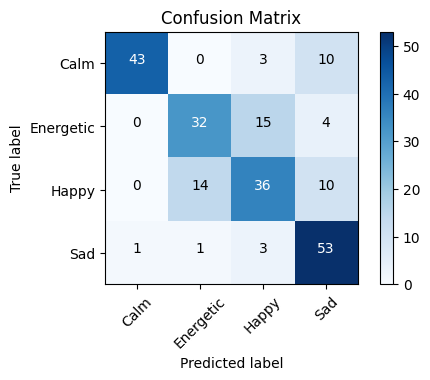

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1 = scaler.fit_transform(df[col_features])
X_combined1 = np.concatenate((X1, lyrics_tfidf_features), axis=1)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_combined1, y_encoded, test_size=0.25, random_state=42)
print(X_combined1.shape, X_train.shape)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class ConvNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConvNet, self).__init__()
        self.input_size = input_size 
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        conv_output_size = ((input_size - 2) // 2) * 16
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

input_size = X_combined1.shape[1]
num_classes = 4 
model = ConvNet(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
y_preds2 = []
y_true2 = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_preds2.extend(predicted.tolist())
        y_true2.extend(targets.tolist())

accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2f}")

y_pred_decoded = label_encoder.inverse_transform(y_preds2)
y_test = label_encoder.inverse_transform(y_true2)

cnf_matrix_cnn = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()


### Neural Networks
#### 3 linear layers

Epoch [1/70] Loss: 1.0728548765182495
Epoch [2/70] Loss: 0.9338617920875549
Epoch [3/70] Loss: 0.2818892300128937
Epoch [4/70] Loss: 0.07160655409097672
Epoch [5/70] Loss: 0.33207812905311584
Epoch [6/70] Loss: 0.000525368785019964
Epoch [7/70] Loss: 0.018390903249382973
Epoch [8/70] Loss: 0.0003776891389861703
Epoch [9/70] Loss: 0.01197571400552988
Epoch [10/70] Loss: 0.010660573840141296
Epoch [11/70] Loss: 0.01150194089859724
Epoch [12/70] Loss: 0.0008703813073225319
Epoch [13/70] Loss: 0.010046311654150486
Epoch [14/70] Loss: 1.0331458497603307e-06
Epoch [15/70] Loss: 1.6768490240792744e-05
Epoch [16/70] Loss: 0.02153349108994007
Epoch [17/70] Loss: 2.3563081413158216e-05
Epoch [18/70] Loss: 0.000965984130743891
Epoch [19/70] Loss: 0.011462315917015076
Epoch [20/70] Loss: 0.0009884192841127515
Epoch [21/70] Loss: 0.0009181743953377008
Epoch [22/70] Loss: 0.07708292454481125
Epoch [23/70] Loss: 0.001255554030649364
Epoch [24/70] Loss: 0.00047307819477282465
Epoch [25/70] Loss: 0.003

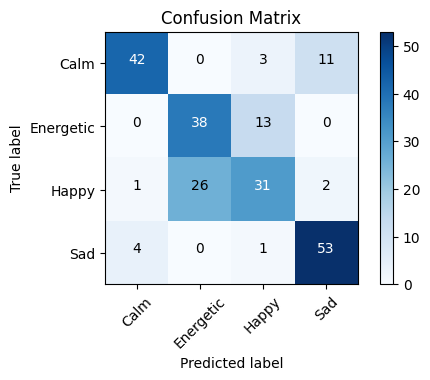

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_size = X_combined.shape[1]
hidden_size1 = 128
hidden_size2 = 256
num_classes = 4  
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
y_preds = []
y_true = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_preds.extend(predicted.tolist())
        y_true.extend(targets.tolist())


accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2f}")


y_pred_decoded = label_encoder.inverse_transform(y_preds)
y_test = label_encoder.inverse_transform(y_true)

cnf_matrix_nn2 = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_nn2, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()

In [39]:
### Neural Network
#### 4 linear layers

Epoch [1/120] Loss: 1.3441033363342285
Epoch [2/120] Loss: 1.3444095849990845
Epoch [3/120] Loss: 1.2007075548171997
Epoch [4/120] Loss: 1.2532367706298828
Epoch [5/120] Loss: 1.0459250211715698
Epoch [6/120] Loss: 0.6992262005805969
Epoch [7/120] Loss: 0.8886575102806091
Epoch [8/120] Loss: 0.40368592739105225
Epoch [9/120] Loss: 0.5343297123908997
Epoch [10/120] Loss: 0.6587429642677307
Epoch [11/120] Loss: 0.17611712217330933
Epoch [12/120] Loss: 0.24789105355739594
Epoch [13/120] Loss: 1.39144766330719
Epoch [14/120] Loss: 0.60773104429245
Epoch [15/120] Loss: 0.2024540901184082
Epoch [16/120] Loss: 0.2180514931678772
Epoch [17/120] Loss: 0.10356056690216064
Epoch [18/120] Loss: 0.2707926630973816
Epoch [19/120] Loss: 0.19275666773319244
Epoch [20/120] Loss: 0.37964606285095215
Epoch [21/120] Loss: 0.2463512271642685
Epoch [22/120] Loss: 0.15441077947616577
Epoch [23/120] Loss: 0.15659423172473907
Epoch [24/120] Loss: 0.007903835736215115
Epoch [25/120] Loss: 0.5962662100791931
Epo

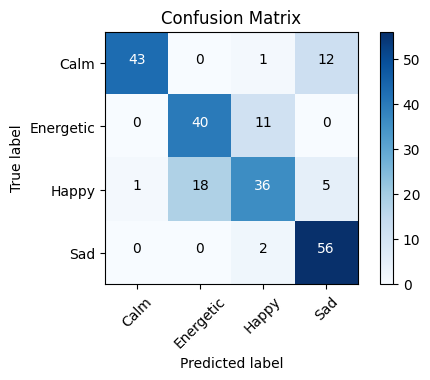

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

input_size = X_combined.shape[1]
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
num_classes = 4  
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 120
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
y_preds = []
y_true = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_preds.extend(predicted.tolist())
        y_true.extend(targets.tolist())


accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2f}")


y_pred_decoded = label_encoder.inverse_transform(y_preds)
y_test = label_encoder.inverse_transform(y_true)

cnf_matrix_nn2 = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_nn2, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()

### Neural Network
#### using graph normalization

Epoch [1/80] Loss: 0.6395366191864014
Epoch [2/80] Loss: 0.24917684495449066
Epoch [3/80] Loss: 0.1743924468755722
Epoch [4/80] Loss: 0.42763665318489075
Epoch [5/80] Loss: 1.1121941804885864
Epoch [6/80] Loss: 0.009521689265966415
Epoch [7/80] Loss: 0.022488350048661232
Epoch [8/80] Loss: 0.04436394199728966
Epoch [9/80] Loss: 0.0015829444164410233
Epoch [10/80] Loss: 0.002240215428173542
Epoch [11/80] Loss: 0.005415258463472128
Epoch [12/80] Loss: 0.0009639225318096578
Epoch [13/80] Loss: 0.005330661311745644
Epoch [14/80] Loss: 0.0015479768626391888
Epoch [15/80] Loss: 0.0005994766834191978
Epoch [16/80] Loss: 0.0015056398697197437
Epoch [17/80] Loss: 0.0013003316707909107
Epoch [18/80] Loss: 0.0009841296123340726
Epoch [19/80] Loss: 0.08994410187005997
Epoch [20/80] Loss: 0.00706653343513608
Epoch [21/80] Loss: 0.02591136284172535
Epoch [22/80] Loss: 0.0016660381807014346
Epoch [23/80] Loss: 0.00017101068806368858
Epoch [24/80] Loss: 0.0002891169278882444
Epoch [25/80] Loss: 0.0004

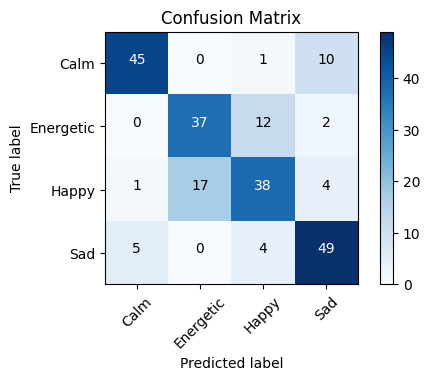

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.gn1 = nn.GroupNorm(num_groups=4, num_channels=hidden_size1)  
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=hidden_size2)  
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.gn3 = nn.GroupNorm(num_groups=8, num_channels=hidden_size3)  
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

input_size = X_combined.shape[1]
hidden_size1 = 128
hidden_size2 = 256
hidden_size3 = 256
num_classes = 4
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
y_preds = []
y_true = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_preds.extend(predicted.tolist())
        y_true.extend(targets.tolist())


accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2f}")


y_pred_decoded = label_encoder.inverse_transform(y_preds)
y_test = label_encoder.inverse_transform(y_true)

cnf_matrix_nn2 = confusion_matrix(y_test, y_pred_decoded)
plt.figure()
plot_confusion_matrix(cnf_matrix_nn2, classes=label_encoder.classes_, title='Confusion Matrix')
plt.show()

### Testing which n-grams combination works well

In [134]:
n_gram_pipeline = dict()
n_gram_pipeline['Unigram'] = (1, 1)
n_gram_pipeline['Bigram'] = (2, 2)
n_gram_pipeline['Trigram'] = (3, 3)
n_gram_pipeline['Unigram + Bigram'] = (1, 2)
n_gram_pipeline['Bigram + Trigram'] = (1, 1)
n_gram_pipeline['Unigram + Bigram  + Trigram'] = (1, 3)

n_gram_tfidf_features_pipeline = dict()
for features in n_gram_pipeline.keys():
        n_gram_tfidf_features_pipeline[features] = TfidfVectorizer(min_df=3, max_features=250, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")
        n_gram_tfidf_features_pipeline[str(features) + " + POS"] = TfidfVectorizer(min_df=3, max_features=250, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english", tokenizer=POSTogging())

models_pipeline = dict()
models_pipeline['Linear SVC'] = LinearSVC(random_state=0, tol=1e-5)
models_pipeline['Logistic Regression'] = LogisticRegression(solver='lbfgs', multi_class='auto')
models_pipeline['Decision Tree'] = DecisionTreeClassifier(max_depth=5)
models_pipeline['Random Forest'] = RandomForestClassifier(max_depth=5, n_estimators=10)
models_pipeline['MLP (ANN)'] = MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500)


text_file = open("model_results.txt","w+")

col_features = df.columns[6:-3]
print(col_features)
X = MinMaxScaler().fit_transform(df[col_features])
Y = df['mood']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

print("Model : Features : train accuracy : test accuracy")
for models_name in models_pipeline.keys():
        for tf_idf in n_gram_tfidf_features_pipeline.keys():
                tf_idf_vectorizer = n_gram_tfidf_features_pipeline[tf_idf]
                model = models_pipeline[models_name]
                lyrics_tfidf_features = tf_idf_vectorizer.fit_transform(preprocessed_lyrics_list).toarray()
                X_combined = np.concatenate((X, lyrics_tfidf_features), axis=1)
                X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.25, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                train_accuracy = accuracy_score(model.predict(X_train), y_train)
                test_accuracy = accuracy_score(y_pred, y_test)

                stream = str(model) + " : " + str(tf_idf) + " : " + str(train_accuracy) + " :" + str(test_accuracy)
                print(stream)
                text_file.write(stream + "\n")
text_file.close()

Index(['popularity', 'length', 'danceability', 'acousticness', 'energy',
       'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
       'tempo', 'key', 'time_signature'],
      dtype='object')
Model : Features : train accuracy : test accuracy


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05) : Unigram : 0.922962962962963 :0.7333333333333333


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/IN', 'between/IN', 'beyond/IN', 'bill/NN', 'both/DT', 'bottom/NN', 'but/CC', 'by/IN', 'call/NN', 'can/MD', 'cannot/NN', 'cant/NN', 'co/NN', 'con/NN', 'could/MD', 'couldnt/NN', 'cry/N

LinearSVC(random_state=0, tol=1e-05) : Unigram + POS : 0.922962962962963 :0.7422222222222222


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB',

LinearSVC(random_state=0, tol=1e-05) : Bigram : 0.9111111111111111 :0.7066666666666667


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05) : Bigram + POS : 0.9185185185185185 :0.7244444444444444


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB',

LinearSVC(random_state=0, tol=1e-05) : Trigram : 0.8340740740740741 :0.7288888888888889


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05) : Trigram + POS : 0.9051851851851852 :0.7022222222222222


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB',

LinearSVC(random_state=0, tol=1e-05) : Unigram + Bigram : 0.922962962962963 :0.7377777777777778


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05) : Unigram + Bigram + POS : 0.9214814814814815 :0.7288888888888889
LinearSVC(random_state=0, tol=1e-05) : Bigram + Trigram : 0.922962962962963 :0.7333333333333333


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB',

LinearSVC(random_state=0, tol=1e-05) : Bigram + Trigram + POS : 0.922962962962963 :0.7422222222222222


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB',

LinearSVC(random_state=0, tol=1e-05) : Unigram + Bigram  + Trigram : 0.922962962962963 :0.7333333333333333


/home/gargi/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05) : Unigram + Bigram  + Trigram + POS : 0.9214814814814815 :0.7333333333333333
LogisticRegression() : Unigram : 0.8681481481481481 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression() : Unigram + POS : 0.8666666666666667 :0.7555555555555555
LogisticRegression() : Bigram : 0.8592592592592593 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression() : Bigram + POS : 0.8666666666666667 :0.7466666666666667
LogisticRegression() : Trigram : 0.8207407407407408 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression() : Trigram + POS : 0.8681481481481481 :0.7333333333333333
LogisticRegression() : Unigram + Bigram : 0.8666666666666667 :0.7644444444444445


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() : Unigram + Bigram + POS : 0.8622222222222222 :0.7422222222222222
LogisticRegression() : Bigram + Trigram : 0.8681481481481481 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression() : Bigram + Trigram + POS : 0.8666666666666667 :0.7555555555555555
LogisticRegression() : Unigram + Bigram  + Trigram : 0.8651851851851852 :0.7688888888888888


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression() : Unigram + Bigram  + Trigram + POS : 0.8637037037037038 :0.7422222222222222
DecisionTreeClassifier(max_depth=5) : Unigram : 0.8696296296296296 :0.7555555555555555
DecisionTreeClassifier(max_depth=5) : Unigram + POS : 0.8755555555555555 :0.7688888888888888
DecisionTreeClassifier(max_depth=5) : Bigram : 0.8622222222222222 :0.7688888888888888


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


DecisionTreeClassifier(max_depth=5) : Bigram + POS : 0.8681481481481481 :0.7733333333333333
DecisionTreeClassifier(max_depth=5) : Trigram : 0.8622222222222222 :0.7777777777777778


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


DecisionTreeClassifier(max_depth=5) : Trigram + POS : 0.8637037037037038 :0.7733333333333333
DecisionTreeClassifier(max_depth=5) : Unigram + Bigram : 0.8681481481481481 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


DecisionTreeClassifier(max_depth=5) : Unigram + Bigram + POS : 0.8740740740740741 :0.7822222222222223
DecisionTreeClassifier(max_depth=5) : Bigram + Trigram : 0.8696296296296296 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


DecisionTreeClassifier(max_depth=5) : Bigram + Trigram + POS : 0.8755555555555555 :0.7733333333333333
DecisionTreeClassifier(max_depth=5) : Unigram + Bigram  + Trigram : 0.8681481481481481 :0.7555555555555555


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


DecisionTreeClassifier(max_depth=5) : Unigram + Bigram  + Trigram + POS : 0.8740740740740741 :0.7777777777777778
RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram : 0.8340740740740741 :0.7377777777777778


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram + POS : 0.8577777777777778 :0.6888888888888889
RandomForestClassifier(max_depth=5, n_estimators=10) : Bigram : 0.8177777777777778 :0.6933333333333334


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Bigram + POS : 0.837037037037037 :0.72
RandomForestClassifier(max_depth=5, n_estimators=10) : Trigram : 0.7985185185185185 :0.7066666666666667


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Trigram + POS : 0.7748148148148148 :0.6533333333333333
RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram + Bigram : 0.8533333333333334 :0.6933333333333334


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram + Bigram + POS : 0.8281481481481482 :0.6977777777777778
RandomForestClassifier(max_depth=5, n_estimators=10) : Bigram + Trigram : 0.8518518518518519 :0.6844444444444444


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Bigram + Trigram + POS : 0.8444444444444444 :0.6933333333333334
RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram + Bigram  + Trigram : 0.8429629629629629 :0.7111111111111111


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(max_depth=5, n_estimators=10) : Unigram + Bigram  + Trigram + POS : 0.8488888888888889 :0.6844444444444444
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram : 0.9718518518518519 :0.6044444444444445


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram + POS : 0.9451851851851852 :0.6533333333333333
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Bigram : 0.9362962962962963 :0.6533333333333333


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Bigram + POS : 0.9718518518518519 :0.6266666666666667
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Trigram : 0.8740740740740741 :0.7244444444444444


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Trigram + POS : 0.9333333333333333 :0.5822222222222222
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram + Bigram : 0.9762962962962963 :0.6311111111111111


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram + Bigram + POS : 0.9777777777777777 :0.6222222222222222
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Bigram + Trigram : 0.9718518518518519 :0.6444444444444445


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Bigram + Trigram + POS : 0.9688888888888889 :0.5733333333333334
MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram + Bigram  + Trigram : 0.9748148148148148 :0.6177777777777778


/home/gargi/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500) : Unigram + Bigram  + Trigram + POS : 0.9896296296296296 :0.5822222222222222
